---
This notebook preprocesses the raw card images and applies several transformations.

First we'll crop the images and save them in `processed-images/`.

---

In [ ]:
import os
from PIL import Image
from tqdm import tqdm


card_width = 352
card_height = 550
input_directory = 'card-images'
output_directory = 'cropped-images'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

for filename in tqdm(os.listdir(input_directory), leave=True):
  input_path = os.path.join(input_directory, filename)
  image = Image.open(input_path)
  cropped_image = image.crop((0, 0, card_width, card_height))
  output_path = os.path.join(output_directory, filename)
  cropped_image.save(output_path)

100%|██████████| 81/81 [00:04<00:00, 16.13it/s]


---
Now we'll darken and lighten some images.

---

In [ ]:
import random
import numpy as np


input_directory = 'cropped-images'
output_directory = 'intensified-images'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

# The brightening / lightening happens by multipliying pixels by some value on (0.8, 1.2).
number_of_intensifications = 3
intensification_range = np.arange(0.8, 1.2, 0.01)
random.seed(2)
for filename in tqdm(os.listdir(input_directory), leave=True):
  params = {
    'number': filename.split('-')[0],
    'color': filename.split('-')[1],
    'texture': filename.split('-')[2],
    'shape': filename.split('-')[3].split('.png')[0],
  }
  input_path = os.path.join(input_directory, filename)
  image = Image.open(input_path)
  intensifications_to_apply = random.sample(intensification_range, number_of_intensifications)
  for intensification in intensifications_to_apply:
    params['intensification'] = intensification
    intensified_image = image.point(lambda p: p * intensification)
    new_filename = '%s-%s-%s-%s-%0.2fi.png' % (
      params['number'], params['color'], params['texture'], params['shape'], intensification)
    output_path = os.path.join(output_directory, new_filename)
    intensified_image.save(output_path)


 46%|████▌     | 37/81 [00:03<00:04,  8.82it/s]

---
And we'll apply several random rotations to each image.

---

In [ ]:
input_directory = 'intensified-images'
output_directory = 'rotated-images'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

# Our rotations are randomly selected to be +/- 30deg.
number_of_rotations = 3
rotation_range = range(0, 30)
rotation_range.extend(range(330, 359))
# Capture the output dimensions of the largest images --
# we'll later make all images this size.
largest_width, largest_height = 0, 0
for filename in tqdm(os.listdir(input_directory), leave=True):
  params = {
    'number': filename.split('-')[0],
    'color': filename.split('-')[1],
    'texture': filename.split('-')[2],
    'shape': filename.split('-')[3],
    'intensification': filename.split('-')[4].split('.png')[0],
  }
  input_path = os.path.join(input_directory, filename)
  image = Image.open(input_path)
  rotations_to_apply = random.sample(rotation_range, number_of_rotations)
  for rotation in rotations_to_apply:
    params['rotation'] = rotation
    rotated_image = image.rotate(rotation, expand=True, resample=Image.BICUBIC)
    new_filename = '%s-%s-%s-%s-%s-%sdeg.png' % (
      params['number'], params['color'], params['texture'], params['shape'], params['intensification'], rotation)
    output_path = os.path.join(output_directory, new_filename)
    rotated_image.save(output_path)
    if rotated_image.width > largest_width:
      largest_width = rotated_image.width
    if rotated_image.height > largest_height:
      largest_height = rotated_image.height

---
Make sure each image is the same size.

---

In [12]:
input_directory = 'rotated-images'
output_directory = 'equally-sized-images'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)
  
for filename in tqdm(os.listdir(input_directory), leave=True):
  input_path = os.path.join(input_directory, filename)
  output_path = os.path.join(output_directory, filename)
  image = Image.open(input_path)
  if image.width < largest_width or image.height < largest_height:
    new_image = Image.new('RGB', (largest_width, largest_height), color=(255, 255, 255))
    new_image.putalpha(255)
    left_padding = (largest_width - image.width) / 2
    top_padding = (largest_height - image.height) / 2
    new_image.paste(image, (left_padding, top_padding))
    new_image.save(output_path)
  else:
    image.save(output_path)

100%|██████████| 715/715 [01:06<00:00, 10.06it/s]


---
Let's display a few..

---

3-purple-empty-oval-0-27deg.png, size: (580, 654)


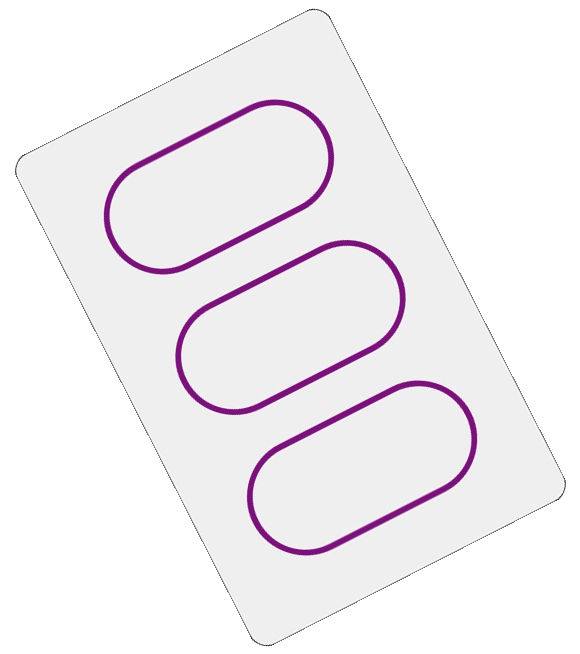

2-red-striped-diamond-1-331deg.png, size: (580, 654)


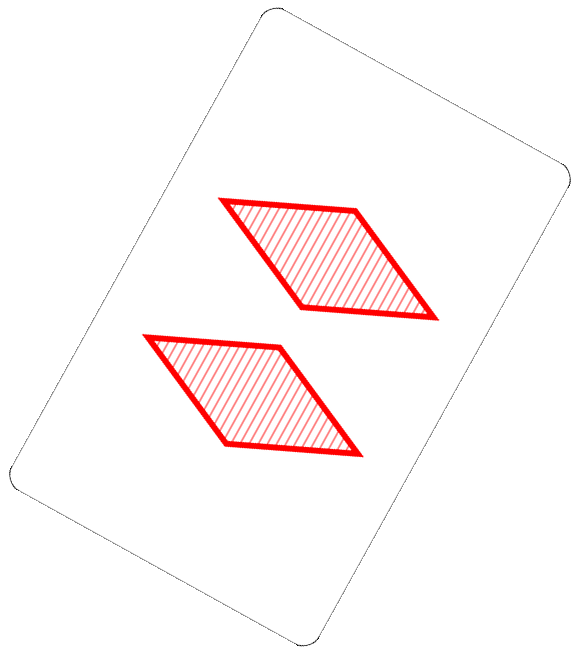

3-purple-solid-oval-349.png, size: (580, 654)


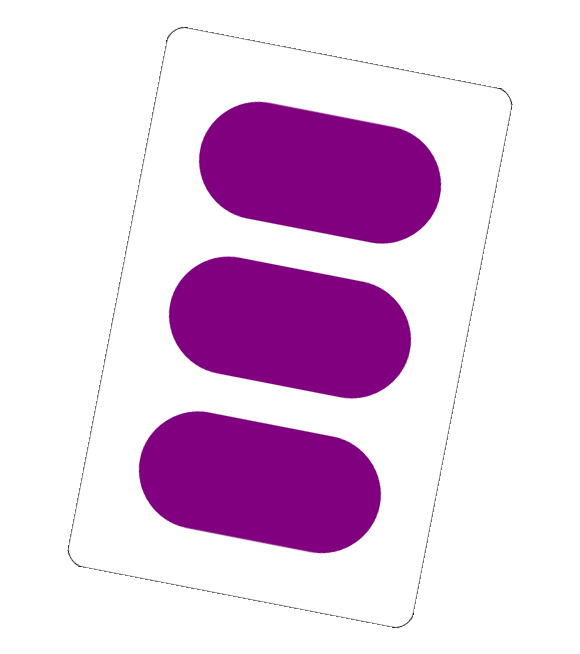

In [11]:
from IPython import display


images = random.sample(os.listdir(output_directory), 3)
for filename in images:
  path = os.path.join(output_directory, filename)
  print '%s, size: %s' % (filename, Image.open(path).size)
  display.display(display.Image(filename=path))

---
These images are 638 x 638..kinda large -- let's shrink them.

---

In [15]:
input_directory = 'equally-sized-images'
output_directory = 'resized-images'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)
  
width, height = 150, 150

for filename in tqdm(os.listdir(input_directory), leave=True):
  input_path = os.path.join(input_directory, filename)
  image = Image.open(input_path)
  resized_image = image.resize((width, height), resample=Image.ANTIALIAS)
  output_path = os.path.join(output_directory, filename)
  resized_image.save(output_path)

100%|██████████| 243/243 [00:09<00:00, 24.63it/s]


---
And now let's see what our images look like..

---

3-red-solid-oval-1.png, size: (150, 150)


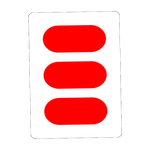

3-purple-empty-oval-21.png, size: (150, 150)


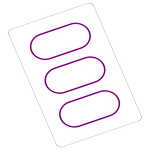

3-red-solid-bean-4.png, size: (150, 150)


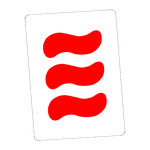

In [16]:
for filename in images:
  path = os.path.join(output_directory, filename)
  print '%s, size: %s' % (filename, Image.open(path).size)
  display.display(display.Image(filename=path))

---
Let's also create a greyscaled versions of these images -- some classifiers will use RGB images, others don't need the color data.

---

In [17]:
input_directory = 'resized-images'
output_directory = 'greyscaled-images'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

for filename in tqdm(os.listdir(input_directory), leave=True):
  input_path = os.path.join(input_directory, filename)
  image = Image.open(input_path)
  greyscaled_image = image.convert('L')
  output_path = os.path.join(output_directory, filename)
  greyscaled_image.save(output_path)

100%|██████████| 243/243 [00:00<00:00, 247.76it/s]


---
And let's view them..

---

3-red-solid-oval-1.png


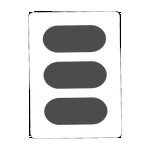

3-purple-empty-oval-21.png


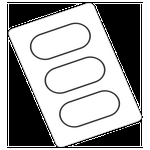

3-red-solid-bean-4.png


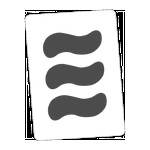

In [18]:
for filename in images:
  path = os.path.join(output_directory, filename)
  print filename
  display.display(display.Image(filename=path))

---
Finally let's convert the RGB and greyscale images into .npy data files.

RGB data first:

---

In [19]:
import numpy as np


input_directory = 'resized-images'
output_directory = 'rgb-data'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

for filename in tqdm(os.listdir(input_directory), leave=True):
  input_path = os.path.join(input_directory, filename)
  image = Image.open(input_path)
  rgba_data = np.array(image).flatten()
  output_filename = '%s.npy' % filename.split('.')[0]
  output_path = os.path.join(output_directory, output_filename)
  np.save(output_path, rgba_data)

100%|██████████| 243/243 [00:00<00:00, 369.11it/s]


---
We should be able to display the numpy data.

---

3-red-striped-oval-331.png


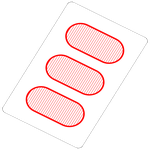

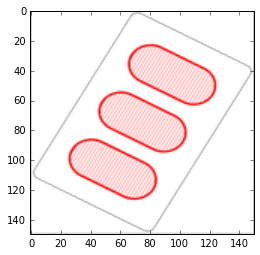

In [20]:
% matplotlib inline
import matplotlib.pyplot as plt


print filename

# Show the original image.
display.display(display.Image(filename=input_path))

# And show the loaded data.
data = np.load(output_path)
rgba = data.reshape(150, 150, 4)
_ = plt.imshow(rgba)

---
And the greyscaled data:

---

In [21]:
input_directory = 'greyscaled-images'
output_directory = 'greyscaled-data'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

for filename in tqdm(os.listdir(input_directory), leave=True):
  input_path = os.path.join(input_directory, filename)
  image = Image.open(input_path).convert('L')
  greyscaled_data = np.array(image).flatten()
  output_filename = '%s.npy' % filename.split('.')[0]
  output_path = os.path.join(output_directory, output_filename)
  np.save(output_path, greyscaled_data)

100%|██████████| 243/243 [00:00<00:00, 549.18it/s]


---
Let's display the greyscaled data too.

---

3-red-striped-oval-331.png


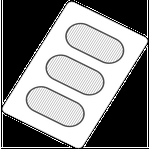

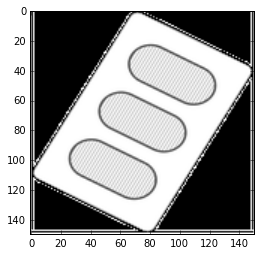

In [22]:
print filename

# Show the original image.
display.display(display.Image(filename=input_path))

# And show the loaded data.
data = np.load(output_path)
two_d = data.reshape(150, 150, 1)
tiled = np.tile(two_d, 3)
_ = plt.imshow(tiled)